In [44]:
source("../../BrusselSprouts/scripts/functions.R")
files=list.files(path = "~/data/trd/genotypes", pattern = ".mpileup-readable.txt.gz$", full.names = TRUE)
files=naturalsort(files)
files

[1] "/home/jnrunge/data/trd/genotypes/YJNRC2.mpileup-readable.txt.gz" 
[2] "/home/jnrunge/data/trd/genotypes/YJNRC17.mpileup-readable.txt.gz"
[3] "/home/jnrunge/data/trd/genotypes/YJNRC18.mpileup-readable.txt.gz"

In [45]:
i=1

In [46]:
sample=getFirst_v2(basename(files[i]), split=".")
sample

[1] "YJNRC2"

In [47]:
SameAllele=function(x){
    # bcftools does not let me compare GTs between samples, so here I am finding the few instances where my loci filter does not work (when both are 2/2 I think)
    a1=substr(OHLoci$V6[x],1,1)
    a2=substr(OHLoci$V7[x],1,1)
    
    return(a1==a2)
}

In [48]:
getDP=function(x){
    DP_pos=which(strsplit(OHLoci$V5[x],":",fixed=TRUE)[[1]]=="DP")
    DP1=as.numeric(strsplit(OHLoci$V6[x],":",fixed=TRUE)[[1]][DP_pos])
    DP2=as.numeric(strsplit(OHLoci$V7[x],":",fixed=TRUE)[[1]][DP_pos])
    return(data.frame(DP1=DP1,DP2=DP2))
}

In [49]:
OHLoci=fread(paste0("~/data/TRD/Oppo-Homo-Pos/",sample,".ohloci.GT.gz"))
OHLoci=OHLoci[!unlist(lapply(1:nrow(OHLoci), SameAllele)),]
OHLoci=bind_cols(OHLoci, bind_rows(lapply(1:nrow(OHLoci), getDP)))
head(OHLoci)
nrow(OHLoci)

Warning message in fread(paste0("~/data/TRD/Oppo-Homo-Pos/", sample, "-turned.ohloci.GT.gz")):
"Discarded single-line footer: <<chromosome1	7528>>"


,V1,V2,V3,V4,V5,V6,V7,DP1,DP2
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,chromosome1,986,A,G,GT:AD:DP:GQ:PGT:PID:PL:PS,"0/0:88,0:88:99:.:.:0,120,1800:.","1|1:0,77:77:99:1|1:968_C_T:3458,232,0:968",88,77
2,chromosome1,990,G,"C,A",GT:AD:DP:GQ:PGT:PID:PL:PS,"0/0:108,0,0:108:99:.:.:0,120,1800,120,1800,1800:.","1|1:0,68,0:68:99:1|1:968_C_T:3060,205,0,3060,205,3060:968",108,68
3,chromosome1,2718,C,T,GT:AD:DP:GQ:PGT:PID:PL:PS,"1/1:3,344:347:99:.:.:13541,932,0:.","0/0:35,0:35:62:.:.:0,62,927:.",347,35
4,chromosome1,12361,G,A,GT:AD:DP:GQ:PGT:PID:PL:PS,"0/0:77,0:77:99:.:.:0,120,1800:.","1|1:0,76:76:99:1|1:12361_G_A:3391,229,0:12361",77,76
5,chromosome1,12363,A,G,GT:AD:DP:GQ:PGT:PID:PL:PS,"0/0:77,0:77:99:.:.:0,120,1800:.","1|1:0,83:83:99:1|1:12361_G_A:3706,250,0:12361",77,83
6,chromosome1,13171,T,C,GT:AD:DP:GQ:PGT:PID:PL:PS,"0/0:59,0:59:99:.:.:0,102,1530:.","1|1:0,84:84:99:1|1:13171_T_C:3717,253,0:13171",59,84


[1] 624

In [50]:
data=fread(files[i])
summary(data$countID1-data$countID2)
data=subset(data, paste(chr,pos) %in% paste(OHLoci$V1,OHLoci$V2)) # to implement the fix above but also in case OHLoci has been made stricter since last mpilup
chrs=summarise(group_by(data, chr),maxPos=max(pos))

data$global_pos=data$pos
for(c in 2:length(unique(data$chr))){
    chr=unique(data$chr)[c]
    data$global_pos[data$chr==chr]=data$pos[data$chr==chr]+sum(chrs$maxPos[chrs$chr%in%unique(data$chr)[1:(c-1)]])
}
head(data)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-182.000    0.000    3.000    3.732    8.000  825.000 

ERROR: Error in data$global_pos[data$chr == chr] <- data$pos[data$chr == chr] + : NAs are not allowed in subscripted assignments


In [ ]:
chrs$global_pos=cumsum(chrs$maxPos)

In [51]:
data$sumCount=data$countID1+data$countID2
data=subset(data, sumCount > 0)
data=subset(data, sumCount<=quantile(data$sumCount, 0.95) & sumCount>=quantile(data$sumCount, 0.05))

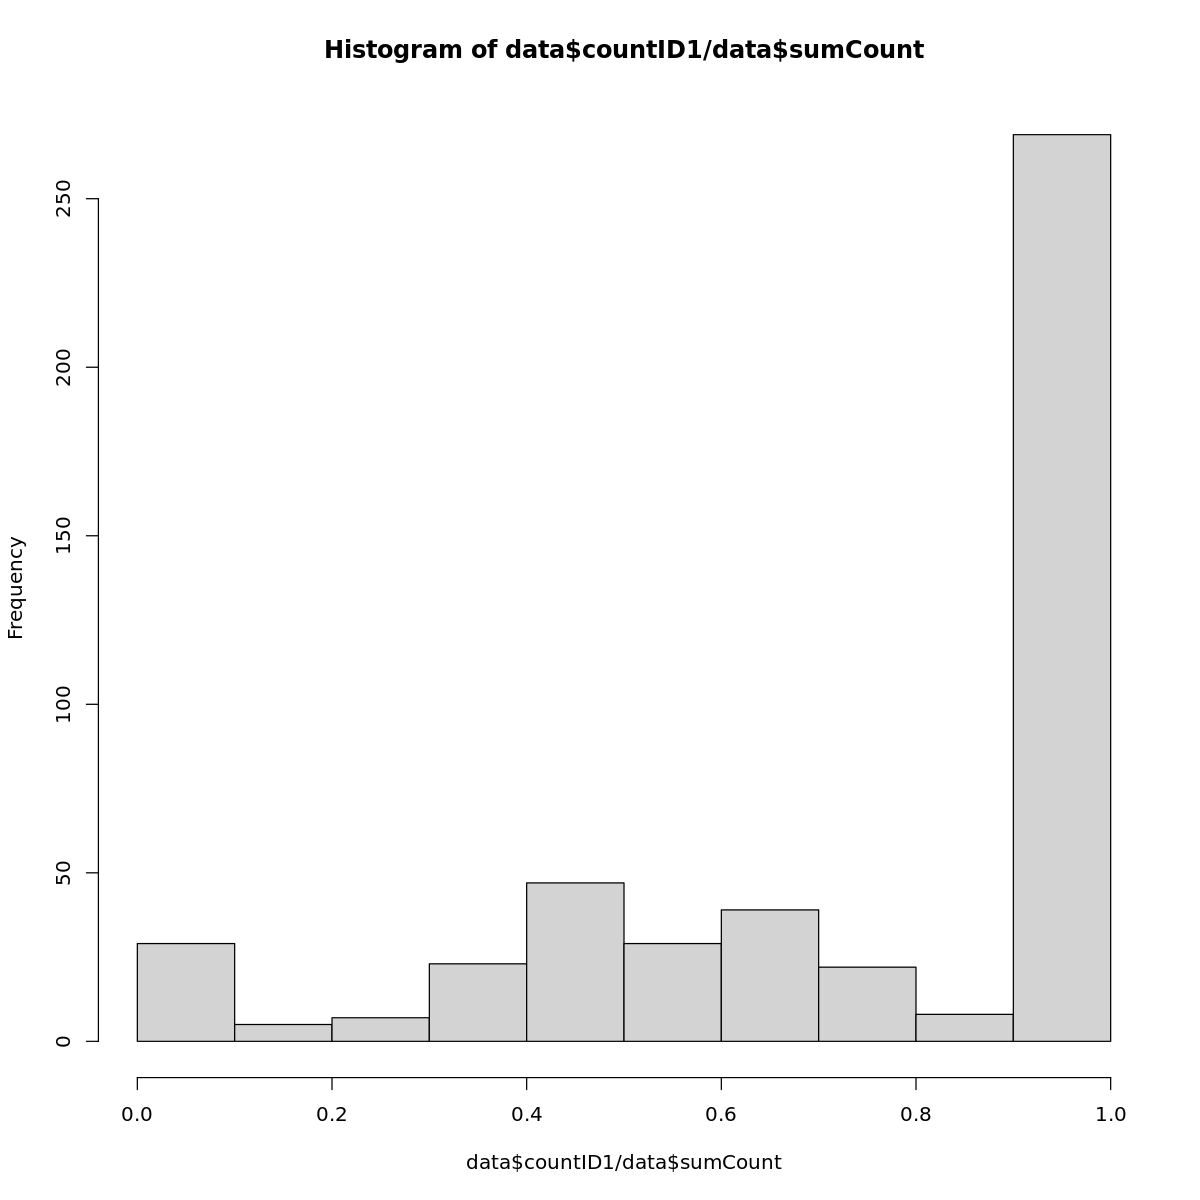

In [52]:
hist(data$countID1/data$sumCount)

In [41]:
head(data)

,chr,pos,countID1,countID2,global_pos,sumCount
,<chr>,<int>,<int>,<int>,<int>,<int>
23,chromosome1,13609,6,0,13609,6
24,chromosome1,13624,5,0,13624,5
26,chromosome1,13640,4,0,13640,4
30,chromosome1,13760,4,0,13760,4
31,chromosome1,13766,4,0,13766,4
32,chromosome1,13771,5,0,13771,5


In [42]:
#fwrite(badLoci<-subset(data, sumCount>=10 & countID1 == sumCount, select=c("chr","pos")), "~/tmpBadAlleles.tsv", sep="\t", col.names = FALSE)

#mpileup=fread("~/data/trd/genotypes/YJNRC2.mpileup.txt.gz")
#mpileup=subset(mpileup,paste(V1,V2) %in% paste(badLoci$chr,badLoci$pos))
#mpileup

In [43]:
data[data$countID1==data$sumCount,]

,chr,pos,countID1,countID2,global_pos,sumCount
,<chr>,<int>,<int>,<int>,<int>,<int>
23,chromosome1,13609,6,0,13609,6
24,chromosome1,13624,5,0,13624,5
26,chromosome1,13640,4,0,13640,4
30,chromosome1,13760,4,0,13760,4
31,chromosome1,13766,4,0,13766,4
32,chromosome1,13771,5,0,13771,5
33,chromosome1,13782,4,0,13782,4
83,chromosome1,15289,4,0,15289,4
128,chromosome1,16413,4,0,16413,4


In [16]:
OHLoci_AF1=subset(OHLoci, paste(V1,V2) %in% paste(data$chr[data$countID1==data$sumCount],
                                                 data$pos[data$countID1==data$sumCount]))

In [17]:
head(OHLoci_AF1)

,V1,V2,V3,V4,V5,V6,V7
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
754,chromosome1,13609,T,C,GT:AD:DP:GQ:PGT:PID:PL:PS,"1/1:0,214:214:99:.:.:8186,641,0:.","0/0:249,0:249:99:.:.:0,120,1800:."
764,chromosome1,13624,C,T,GT:AD:DP:GQ:PGT:PID:PL:PS,"1/1:0,194:194:99:.:.:7232,580,0:.","0/0:249,0:249:99:.:.:0,120,1800:."
772,chromosome1,13640,C,T,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,177:177:99:1|1:13636_G_A:7796,532,0:13636","0/0:249,0:249:99:.:.:0,120,1800:."
805,chromosome1,13760,T,G,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,206:206:99:1|1:13754_G_A:9270,620,0:13754","0/0:223,0:223:99:.:.:0,120,1800:."
808,chromosome1,13766,A,G,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,213:213:99:1|1:13754_G_A:9564,641,0:13754","0/0:223,0:223:99:.:.:0,120,1800:."
811,chromosome1,13771,A,G,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,214:214:99:1|1:13754_G_A:9547,644,0:13754","0/0:223,0:223:99:.:.:0,120,1800:."


`geom_smooth()` using formula = 'y ~ x'


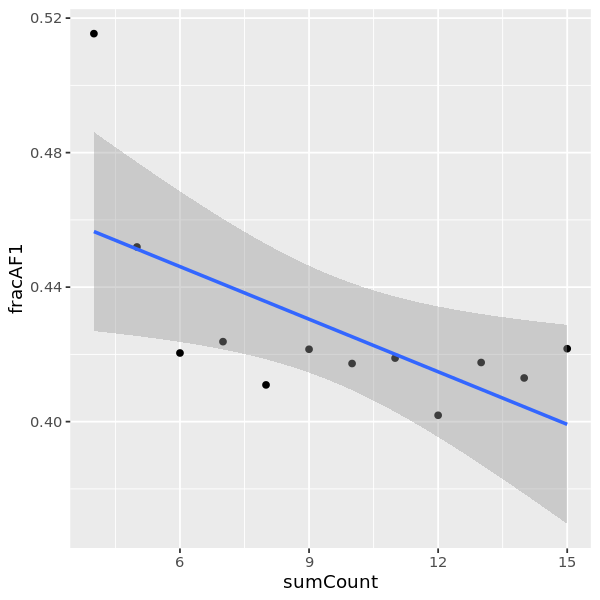

In [18]:
options(repr.plot.width=5, repr.plot.height=5)
data_summary_AF1=summarise(group_by(data, sumCount), fracAF1=sum(countID1==sumCount)/n())
ggplot(data_summary_AF1, aes(sumCount,fracAF1))+
geom_point()+geom_smooth(method="lm")

In [19]:
mean(data$countID1/data$sumCount)

[1] 0.7140988

In [20]:
summarise(group_by(data,chr), meanAF=mean(countID1/sumCount))

chr,meanAF
<chr>,<dbl>
chromosome1,0.7748266
chromosome10,0.6993165
chromosome11,0.7125550
chromosome12,0.7348380
chromosome13,0.6938316
chromosome14,0.7274719
chromosome15,0.7263675
chromosome16,0.6499187
chromosome2,0.6936317


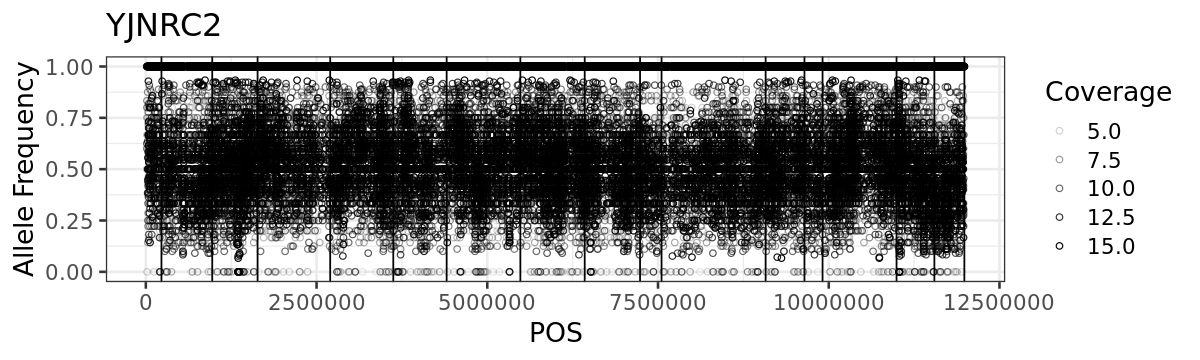

In [21]:
options(repr.plot.width=10, repr.plot.height=3)


print(ggplot(data, aes(global_pos, countID1/sumCount, alpha=sumCount))+
geom_point(shape=1)+
geom_vline(xintercept = chrs$global_pos)+theme_bw(16)+ylab("Allele Frequency")+xlab("POS")+
ggtitle(sample)+labs(alpha="Coverage"))

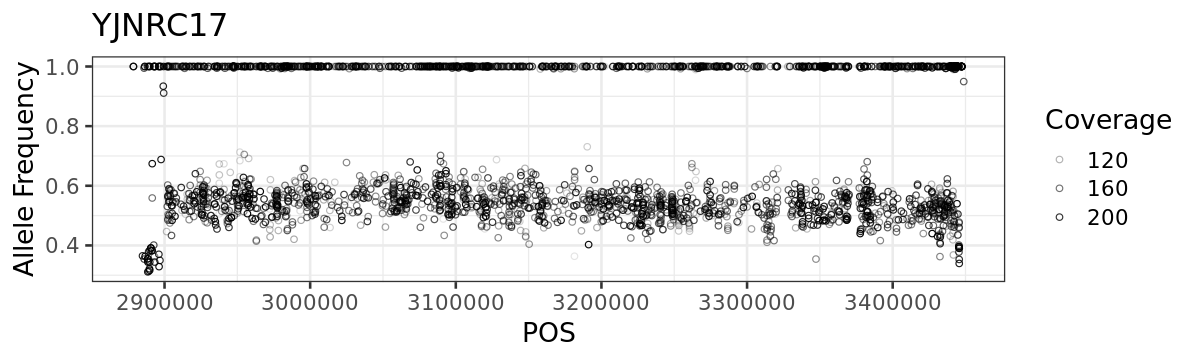

In [225]:
ggplot(subset(data, chr=="chromosome5"), aes(global_pos, countID1/sumCount, alpha=sumCount))+
geom_point(shape=1)+
theme_bw(16)+ylab("Allele Frequency")+xlab("POS")+
ggtitle(sample)+labs(alpha="Coverage")

In [226]:
nrow(subset(data, sumCount>=15 & countID1==sumCount)) / nrow(data)

[1] 0.352593